In [21]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from network import Network
from perceptron import Perceptron
from layer import Layer
from tqdm import tqdm
import typing as tp
import matplotlib.pyplot as plt
from copy import deepcopy

sns.set_theme(rc={'figure.figsize': (8.25, 5.875), 'figure.dpi': 100, 'axes.labelpad': 2, 'savefig.pad_inches': .5})

In [22]:
df: pd.DataFrame = pd.read_csv(os.path.join('data', 'group_project_data.csv'))
df

,Data Item,LAC,SOW,TACA
0,1,0.90,0.87,1
1,2,1.81,1.02,0
2,3,1.31,0.75,1
3,4,2.36,1.60,0
4,5,2.48,1.14,0
5,6,2.17,2.08,1
6,7,0.41,1.87,0
7,8,2.85,2.91,1
8,9,2.45,0.52,0
9,10,1.05,1.93,0


In [23]:
def get_network(use_biases: bool) -> Network:
    return (Network()
    .add_layer(
        Layer(num_in_features=2,
              num_out_features=2,
              is_hidden_layer=True,
              # initial_weights=[np.ones(2) * 0.3, np.ones(2) * 0.3],
              use_biases=use_biases))
    .add_layer(
        Layer(num_in_features=2,
              num_out_features=1,
              is_hidden_layer=False,
              # initial_weights=[np.ones(2) * 0.8],
              use_biases=use_biases)))

def get_average_error(net: Network, x: np.ndarray, y: np.ndarray) -> float:
    tot_error: float = 0
    for i in range(x.shape[0]):
        net.feedforward(x[i])
        tot_error += net.get_total_error(y[i])
    return tot_error

In [24]:
network: Network = get_network(True)
network

[
	(0) :: Layer(in=2, out=2, is_hidden=True, use_biases=True)
	(1) :: Layer(in=2, out=1, is_hidden=False, use_biases=True)
]

In [25]:
x_cols: tp.List[str] = ['LAC', 'SOW']
y_cols: tp.List[str] = ['TACA']

In [26]:
def min_max_scale(a: np.ndarray) -> np.ndarray:
    min_val: np.ndarray = np.min(a, axis=0)
    max_val: np.ndarray = np.max(a, axis=0)
    return (a - min_val) / (max_val - min_val)

In [27]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [28]:
train_x, test_x, train_y, test_y = train_test_split(df[x_cols].values, df[y_cols].values, random_state=13, train_size=0.8, shuffle=True)
train_x.shape, train_y.shape

((16, 2), (16, 1))

In [52]:
def do_single_data(_net: Network, x: np.ndarray, y: np.ndarray, learning_rate: float, threshold_f: tp.Callable[[float], bool], do_training: bool = True) -> tp.Tuple[Network, bool]:
    net: Network = deepcopy(_net)
    curr_out: np.ndarray = net.feedforward(x)
    if do_training:
        net.backprop(learning_rate, y)
    prediction: bool = threshold_f(curr_out.item())
    return net, prediction

In [53]:
def train_network(_net: Network, x: np.ndarray, y: np.ndarray, n_epochs: int, learning_rate: float, threshold_f: tp.Callable[[float], bool]) -> tp.Tuple[Network, tp.List[tp.Dict[str, tp.Any]]]:
    net: Network = deepcopy(_net)    
    results: tp.List[tp.Dict[str, tp.Any]] = []

    for epoch in range(n_epochs):
        predictions: tp.List[float] = []
        for i in range(x.shape[0]):
            net, pred = do_single_data(net, x[i, :], y[i, :], learning_rate, threshold_f)
            predictions.append(pred)
        curr_error: float = get_average_error(net, x, y)
        f1: float = f1_score(y_pred=np.array(predictions), y_true=y)
        results.append({'epoch': epoch, 'error': curr_error, 'f1_score': f1})
    return net, results

In [64]:
k: int = 4
num_epochs: int = 60
lr: float = 1e-3
threshold: tp.Callable[[float], bool] = lambda f: f >= 0.4

k_folder: KFold = KFold(n_splits=k, shuffle=True, random_state=13)

analysis_results: tp.List[pd.DataFrame] = []

network_results: tp.Dict[int, tp.Tuple[Network, float]] = {}

for fold_idx, (train_idx, test_idx) in enumerate(k_folder.split(train_x, train_y)):
    trained_network, fold_results = train_network(network, train_x[train_idx, :], train_y[train_idx], num_epochs, lr, threshold)
    curr_fold_results: pd.DataFrame = pd.DataFrame.from_records(fold_results)
    curr_fold_results['fold_num'] = fold_idx
    
    test_predictions: tp.List[bool] = [do_single_data(trained_network, train_x[test_i, :], train_y[test_i], lr, threshold, do_training=False)[1] for test_i in test_idx] 
    test_f1_score: float = f1_score(train_y[test_idx], y_pred=np.array(test_predictions).astype(int))
    curr_fold_results['test_f1'] = test_f1_score
    
    network_results[fold_idx] = (trained_network, test_f1_score)
    
    analysis_results.append(curr_fold_results)
results_df: pd.DataFrame = pd.concat(analysis_results)
results_df

,epoch,error,f1_score,fold_num,test_f1
0,0,2.034457,0.588235,0,0.400000
1,1,2.033063,0.588235,0,0.400000
2,2,2.031671,0.588235,0,0.400000
3,3,2.030280,0.588235,0,0.400000
4,4,2.028890,0.588235,0,0.400000
...,...,...,...,...,...
55,55,2.289625,0.400000,3,0.857143
56,56,2.286369,0.400000,3,0.857143
57,57,2.283115,0.400000,3,0.857143
58,58,2.279863,0.400000,3,0.857143


In [65]:
grouped_df: pd.DataFrame = results_df.groupby('fold_num').agg({'f1_score': 'max', 'test_f1': 'max'})
grouped_df

,f1_score,test_f1
fold_num,,
0,0.588235,0.400000
1,0.500000,0.666667
2,0.666667,0.000000
3,0.400000,0.857143


Text(0.5, 1.0, 'K Folds Results From Base Training Dataset')

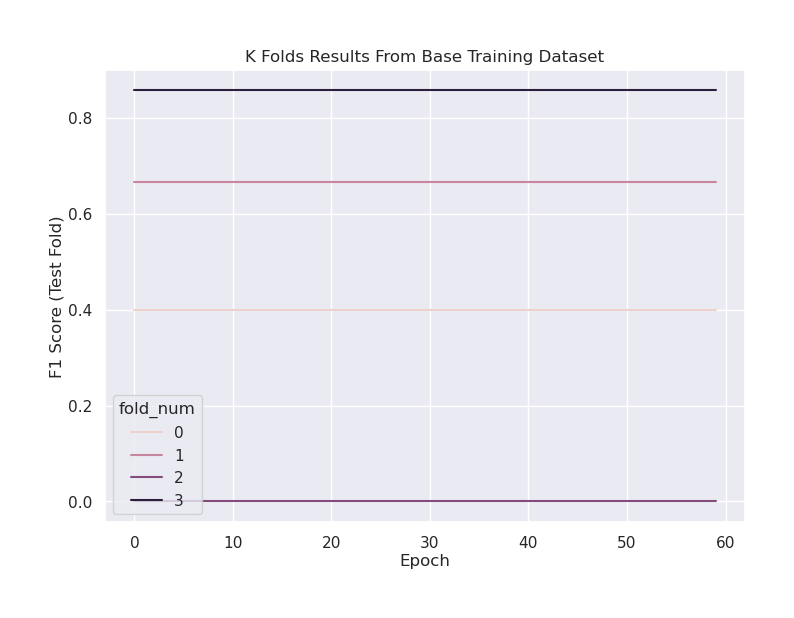

In [66]:
sns.lineplot(data=results_df, x='epoch', y='test_f1', hue='fold_num')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Test Fold)')
plt.title('K Folds Results From Base Training Dataset')

In [67]:
best_k_fold: int = max(network_results.keys(), key=lambda kk: network_results[kk][1])
best_network: Network = network_results[best_k_fold][0]

test_predict: np.ndarray = np.array([do_single_data(best_network, test_x[i, :], test_y[i], lr, threshold, do_training=False)[1] for i in range(test_x.shape[0])]).astype(int)

f1_score(y_pred=test_predict, y_true=test_y)

0.6666666666666666